In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole_map

In [3]:
mapdir = '/scratch/aew492/quasars/maps'
NSIDE = 64
G = 20.5
sf_dip_nomaps = tools.flatten_map(Table.read(os.path.join(mapdir,
                                    f'selection_function_NSIDE{NSIDE}_G{G}_dipole_nomaps.fits'), format='fits'))

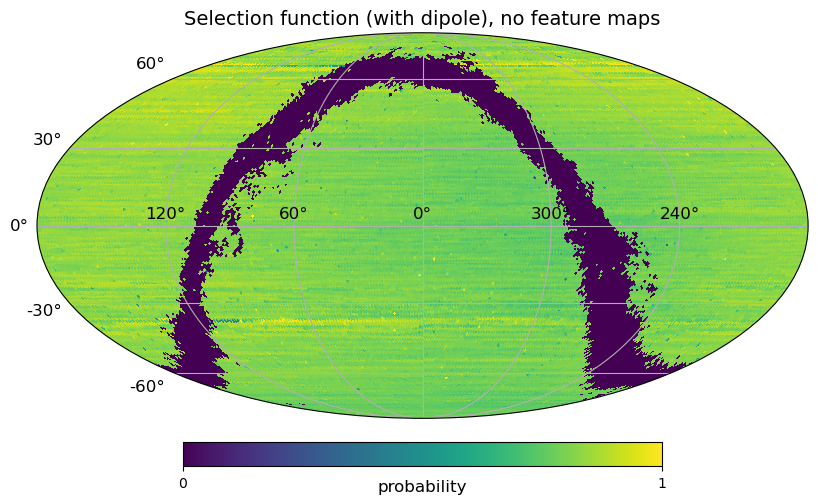

In [4]:
tools.plot_map(sf_dip_nomaps, title='Selection function (with dipole), no feature maps', unit='probability')

In [5]:
# check out recovered dipole
fit_res = np.load(os.path.join(mapdir,
                        f'selection_function_NSIDE{NSIDE}_G{G}_dipole_nomaps-res.npy'), allow_pickle=True).item()

In [6]:
amps = fit_res['x'][:4]
print(amps)
dipmap = dipole_map(amps)

[ 3.32218375 -0.03401345  0.03087487  0.03154362]


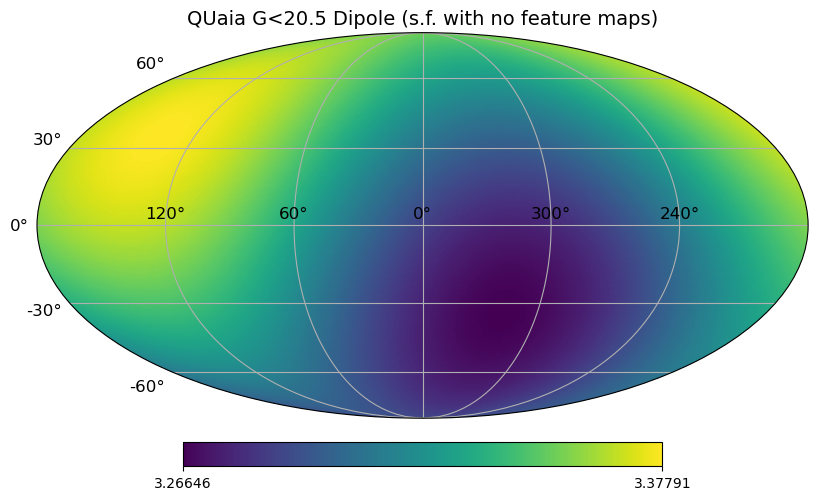

In [7]:
tools.plot_map(dipmap, title=f'QUaia G<{G} Dipole (s.f. with no feature maps)')

#### healpy `fit_dipole`

In [8]:
map_quaia = tools.load_catalog_as_map(f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits', NSIDE=64)

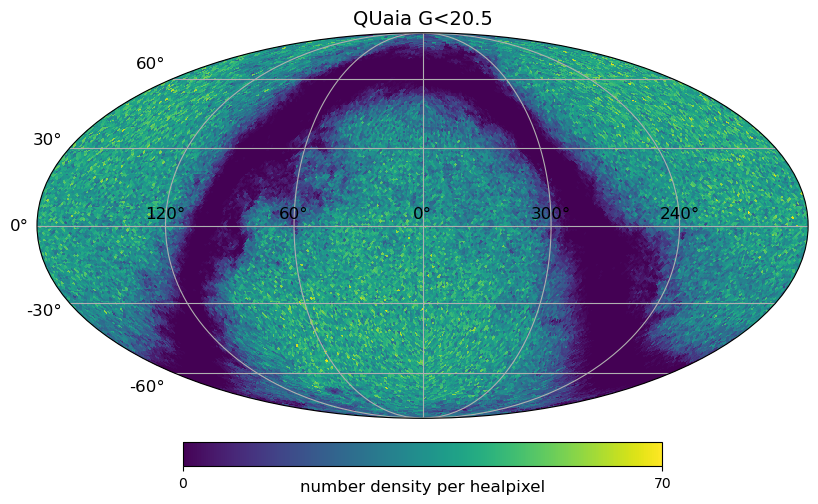

In [9]:
tools.plot_map(map_quaia, title=f'QUaia G<{G}', unit='number density per healpixel')

In [10]:
# fit a dipole to this map, excluding zeros to match the selection function fit
hp_monopole, hp_dipole = hp.fit_dipole(map_quaia, bad=0.)
hp_monopole, hp_dipole

(30.2244788772696, array([-1.38746614,  0.8097788 ,  1.03957557]))

In [11]:
hp_dipmap = dipole_map(np.append(hp_monopole, hp_dipole))

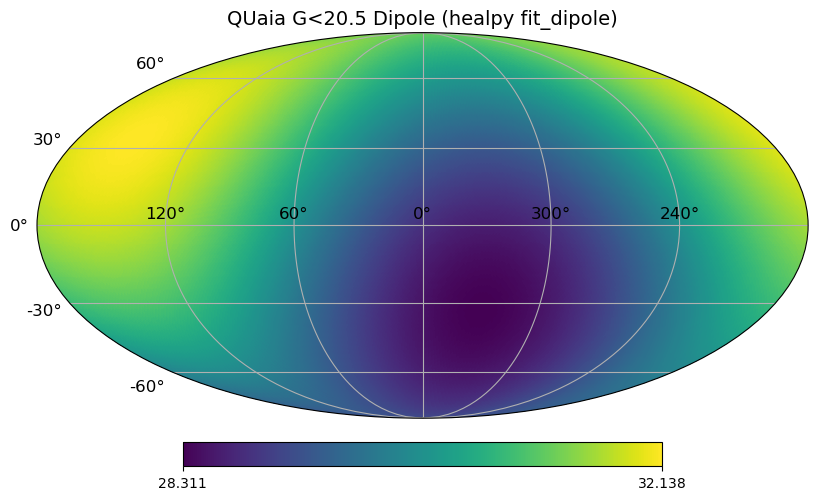

In [12]:
tools.plot_map(hp_dipmap, title=f'QUaia G<{G} Dipole (healpy fit_dipole)')

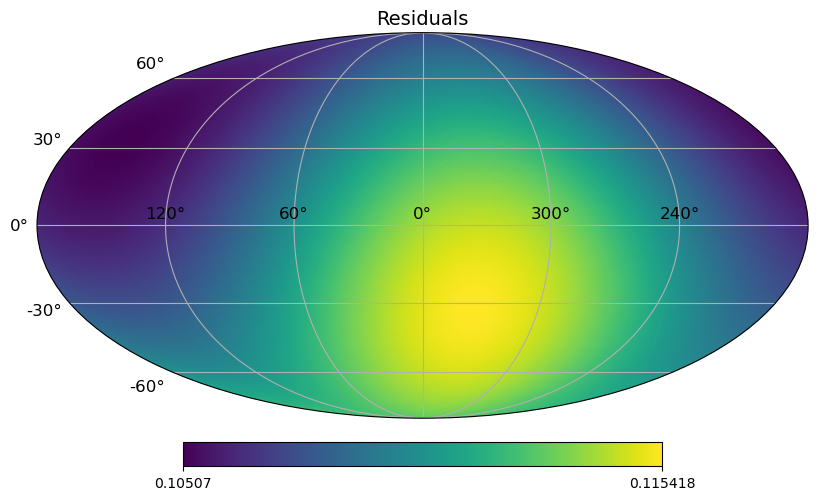

In [13]:
tools.plot_map(dipmap/hp_dipmap, title='Residuals')

In [14]:
# compare directions
lon, lat = hp.rotator.vec2dir(amps[1:], lonlat=True)
print(lon, lat)
lon_hp, lat_hp = hp.rotator.vec2dir(hp_dipole, lonlat=True)
print(lon_hp, lat_hp)

137.7691785086601 34.476490098504904
149.73051473713323 32.907336385722964


$a$ = dipole amp in unscaled map, $b$ = monopole in unscaled map:
\begin{align}
\frac{a}{b} &\equiv c \\
\ln a &= \ln(bc) \\
\ln a &= \ln b + \ln c \\
\frac{\ln a}{\ln b} &= 1 + \frac{\ln c}{\ln b} \\
\end{align}

In [20]:
dip = SkyCoord(lon, lat, unit=u.deg, frame='icrs')
dip_hp = SkyCoord(lon_hp, lat_hp, unit=u.deg, frame='icrs')

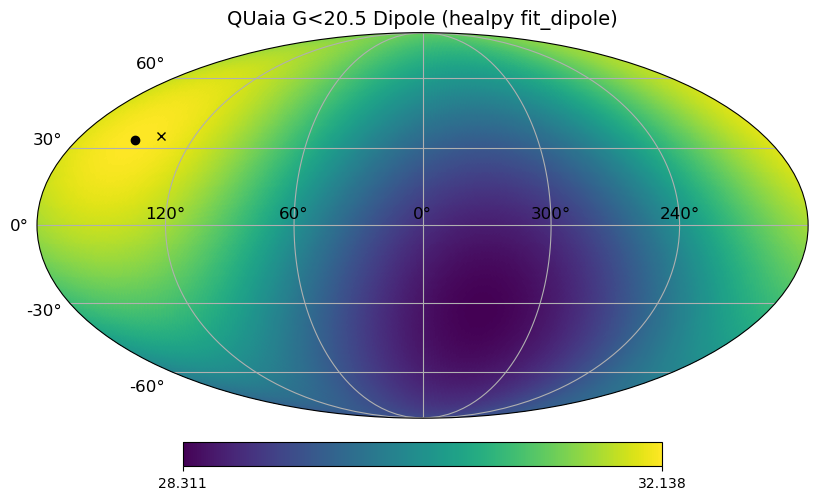

In [22]:
tools.plot_map(hp_dipmap, title=f'QUaia G<{G} Dipole (healpy fit_dipole)')
newprojplot(np.pi/2-dip.dec.rad, dip.ra.rad, marker='x', color='k')
newprojplot(np.pi/2-dip_hp.dec.rad, dip_hp.ra.rad, marker='o', color='k')

Compare amplitudes -

The ones from the selection function are LOG SCALE so we need to correct for that? Then the monopoles should match?

In [23]:
np.log(hp_monopole), amps[0]

(3.408652154905392, 3.3221837528020117)

In [24]:
hp_dipole, amps[1:]

(array([-1.38746614,  0.8097788 ,  1.03957557]),
 array([-0.03401345,  0.03087487,  0.03154362]))

In [25]:
hp_dipole/hp_monopole, amps[1:]/amps[0]

(array([-0.04590538,  0.02679215,  0.03439515]),
 array([-0.01023828,  0.00929355,  0.00949484]))

In [26]:
np.linalg.norm(hp_dipole)/hp_monopole, np.linalg.norm(amps[1:])/amps[0]

(0.06330994917462875, 0.01677332809434082)

In [27]:
np.linalg.norm(hp_dipole)/hp_monopole / np.linalg.norm(amps[1:])/amps[0]

0.34198371268972033